### Imports and configuration

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

from rasterio.enums import Resampling

matplotlib.rc('figure', dpi=150)

binary_cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
confusion_cmap = matplotlib.colors.ListedColormap(['gray', 'green', 'red', 'blue'])

### Helper functions

In [2]:
# makes inundation depth array binary
# 0 is not inundated and 1 is inundated
def make_binary(in_array):
    binary_array = in_array.copy().astype('uint8')
    binary_array = np.where(binary_array <= int(0), int(0), int(1))
    binary_array[binary_array==np.nan] = int(0)
    if isinstance(in_array, np.ma.MaskedArray):
        binary_array = np.ma.masked_array(binary_array, in_array.mask).astype('uint8')
    return binary_array.astype('uint8')

# takes two binary arrays where for each cell
# 0 is not inundated and 1 is inundated
def make_confusion_plot(truth_array, eval_array):
    confusion_classified = np.where(
        ((truth_array == 0) & (eval_array == 0)), 0, # TN = 0
        np.where(
            ((truth_array == 0) & (eval_array == 1)), 1, # FP = 1
            np.where(
                ((truth_array == 1) & (eval_array == 0)), 2, # FN = 2
                np.where(
                    ((truth_array == 1) & (eval_array == 1)), 3, # TP = 3
                    np.nan # else assign NaN
    ))))
    return confusion_classified

def make_confusion_stats(confusion_plot_array):
    _, counts = np.unique(confusion_plot_array, return_counts=True)

    tn = counts[0]
    fp = counts[1]
    fn = counts[2]
    tp = counts[3]

    prop_cor = (tp+tn)/(tn+fp+fn+tp)
    bias_ratio = (tp+fp)/(tp+fn)
    hit_rate = tp/(tp+fn)

    print(
        f"{'True Negative (TN):':<20}{tn:>15}",
        f"\n{'False Positive (FP):':<20}{fp:>15}",
        f"\n{'False Negative (FN):':<20}{fn:>15}",
        f"\n{'True Postive (TP):':<20}{tp:>15}",
        "\n",
        f"\n{'Proportion Correct:':<20}{round(prop_cor,4):>15}",
        f"\n{'Bias Ratio:':<20}{round(bias_ratio,4):>15}",
        f"\n{'Hit Rate:':<20}{round(hit_rate,4):>15}",
    )


def imshow_binary_array(in_array, save_path):
    fig, ax = plt.subplots()

    cax = ax.imshow(
        in_array,
        vmin = 0,
        vmax = 1,
        cmap = binary_cmap
        )

    cbar = fig.colorbar(
        cax,
        ticks=[0,.25,0.5,0.75,1],
        ax=ax,
        fraction=0.046,
        pad=0.03
        )

    cbar.ax.set_yticklabels(
        ['','Not inundated','','Inundated',''],
        rotation=90,
        va='center' # set vertical alignment
        )

    if save_path is not None:
        fig.tight_layout()
        plt.savefig(save_path, facecolor = 'w')
        
    plt.show()

def imshow_confusion(in_array, save_path):
    fig, ax = plt.subplots()

    cax = ax.imshow(
        in_array,
        vmin = 0,
        vmax = 3,
        cmap = confusion_cmap
        )

    cbar = fig.colorbar(
        cax,
        ticks=np.arange(0,4,0.375),
        ax=ax,
        fraction=0.046,
        pad=0.03
        )

    cbar.ax.set_yticklabels(
        ['', 'TN', '', 'FP', '', 'FN', '', 'TP', '','',''],
        rotation=90,
        va = 'center' # centered vertical alignment
        )

    if save_path is not None:
        fig.tight_layout()
        plt.savefig(save_path, facecolor = 'w')
        
    plt.show()

### Open rasters and resample to equal shape

In [3]:
compound_inun = rio.open('data_github/compound_inun_SEP14_alpha1.tif','r')
compound_inun_array = compound_inun.read(1,masked=True)
compound_inun_array_binary = make_binary(compound_inun_array)

SAR_inun = rio.open('data_github/SAR_SEP14_masked_projUTM18n.tif','r')
# resample band 1 of SAR_inun to shape of compound_inun
# with nearest neighbor interpolation
SAR_inun_array = SAR_inun.read(
    1,
    masked=True,
    out_shape=(
        compound_inun_array_binary.shape[0],
        compound_inun_array_binary.shape[1]
    ),
    resampling=Resampling.nearest
)

# assert compound inundation array and SAR inundation array have same shape
assert np.equal(
    compound_inun_array_binary.shape,
    SAR_inun_array.shape
    ).all()

### Plot SAR and compound inundation binary arrays as images

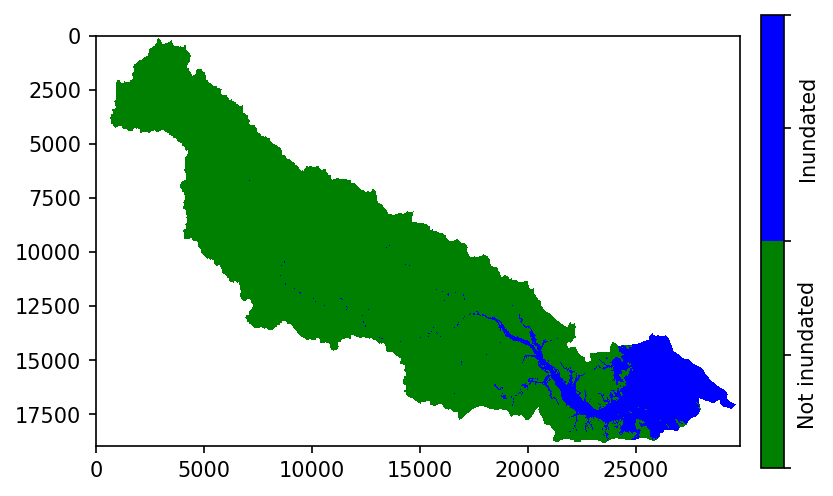

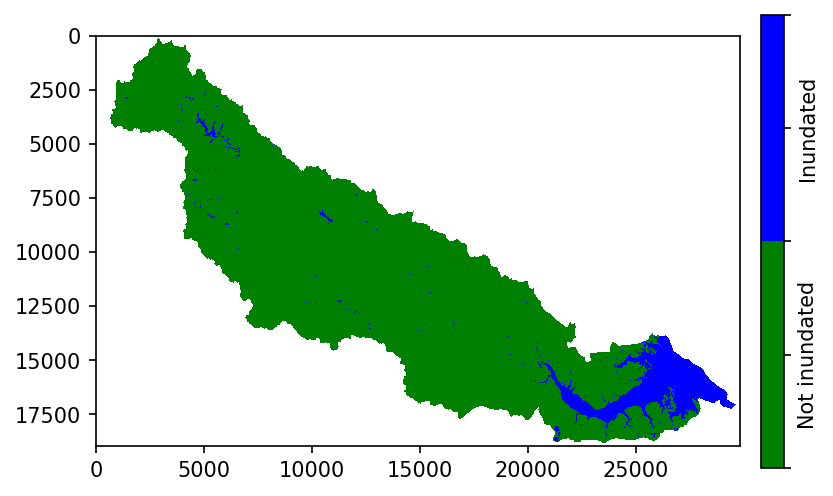

In [4]:
plt.close('all')

# plot compound inundation binary array
imshow_binary_array(
    compound_inun_array_binary,
    save_path = None
    )

# plot SAR binary raster
imshow_binary_array(
    SAR_inun_array,
    save_path = None
    )

### Make confusion matrix, show stats, save .tif and .png

True Negative (TN):       148231495 
False Positive (FP):        8501014 
False Negative (FN):        2445921 
True Postive (TP):         12564667 
 
Proportion Correct:          0.9363 
Bias Ratio:                  1.4034 
Hit Rate:                    0.8371


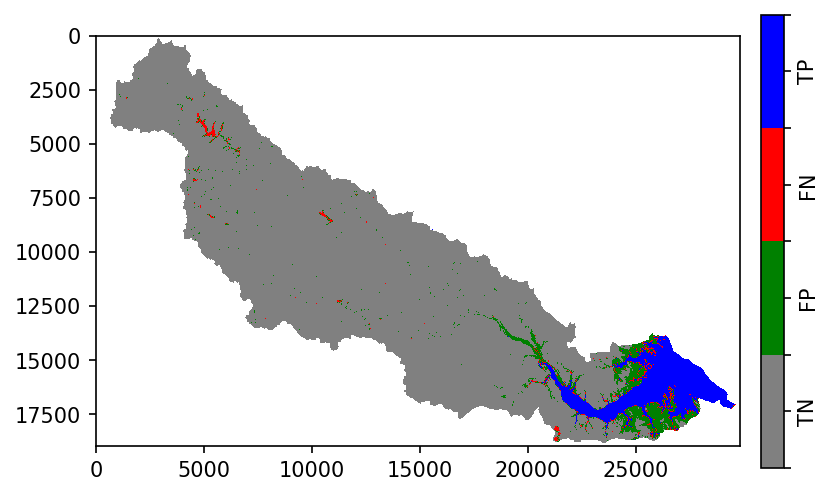

In [5]:
# takes two binary arrays where for each cell
# 0 is not inundated and 1 is inundated
confusion_SAR_compound = make_confusion_plot(SAR_inun_array, compound_inun_array_binary)

make_confusion_stats(confusion_SAR_compound)

# write raster with internal mask (no .msk sidecar)
w_msk = (~compound_inun_array.mask * 255).astype('uint8')
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open(
        'data_github/confusion_SAR_compound_SEP14_alpha1.tif', 'w', 
        **compound_inun.profile) as ds_out:
        ds_out.write(confusion_SAR_compound,1)
        ds_out.write_mask(w_msk)

# plot and save confusion matrix coded fig
imshow_confusion(
    confusion_SAR_compound,
    save_path = None
    )